
# Week 6a: Audio classificiation

This notebook performs audio classification in pytorch, using the SpeechCommands dataset: https://arxiv.org/abs/1804.03209

This code implements a 1-Dimensional Convoluitonal Neural Network that classifies raw waveforms of people speaking different voice instructions. The CNN model implemented here is based on this paper: https://arxiv.org/pdf/1610.00087.pdf

Before running this code you will need to download the dataset using the `download-speech-commands-dataset.ipynb` notebook. 

Work through this notebook and spend time reading the code. Try comparing this code side-by-side with the `train-image-classifier-from-scratch.ipynb` notebook from Week 3 to see the similiarities and differences between the two codebases. Once you have sucessfully trained a model with this code, try some of the tasks at the bottom of the notebook. 

The code in this notebook is heavily modified (for readability and adaptability) from this soruce: https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html


In [1]:
%matplotlib inline

import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchaudio.transforms as transforms

from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Import data util functions from 'src/'
from src.audio_folder_dataset import AudioFolder
from src.audio_folder_collate_fn import collate_audio_folder_batch

### Define hyperparameters

If you have a Mac M1/M2 you can change the device to `mps`, if you have an NVIDIA GPU you can change the device to `cuda`:

In [2]:
device = 'mps'
original_sample_rate = 16000 # Sample rate for the speech commands dataset
new_sample_rate = 8000 # Sample rate for the speech commands dataset
val_size = 0.3 # Size of train / validation split
batch_size = 200 # Batch size for training
num_epochs = 1 # Number of epochs for training (this is a large dataset so not many epochs needed)
log_interval = 20 # Log process every n interations
learning_rate = 0.01 # Learning rate for training
weight_decay = 0.0001 # Weight decay for ADAM optimiser

### Define data transform

When working with torchaudio we can only define one transform here. This function downsamples the audio waveform from a sample rate of 16000 to 8000, which is fine for working with human voices and helps us train more efficiently.

Unlike when working with images, the padding and normalising of the data to the same length happens in the function `collate_audio_folder_batch` in `src/audio_folder_collate_fn.py`. As all of our audio files are different lengths, we need to harmonise them when we load in a random mini-batch. 



In [3]:
transform = transforms.Resample(orig_freq=original_sample_rate, new_freq=new_sample_rate)

### Create datasets

Here we create our dataset classes. Because we are using different transforms, we need to make two seperate dataset classes. We will then take a random sub-selection of our data and split our dataset into two. 

When we do the split, by setting `random_state=42`, we are doing this in a deterministic way, such that we will always get the same 'random' split of data into the training and validation sets.

In [4]:
train_path = '../data/class-datasets/speech-commands/train/'

dataset = AudioFolder(train_path, transform=transform)
num_classes = len(dataset.classes)

# Get length of dataset and indicies
num_train = len(dataset)
indices = list(range(num_train))

# Get train / val split for data points
train_indices, val_indices = train_test_split(indices, test_size=val_size, random_state=42)

# Override dataset classes to only be samples for each split
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, collate_fn=collate_audio_folder_batch, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, collate_fn=collate_audio_folder_batch,  shuffle=False)

### Plot a sample of the data

Data batch shape: torch.Size([200, 1, 8000])
Shape of waveform: torch.Size([8000])
Class of waveform: 'up'


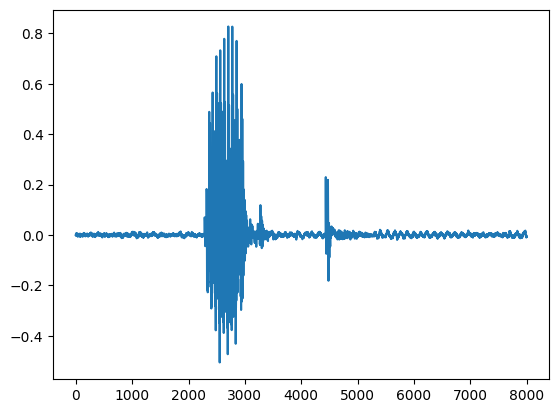

In [5]:
data_batch, label_batch = next(iter(train_loader))
sample_waveform = data_batch[0].squeeze()
print(f'Data batch shape: {data_batch.shape}')
print(f"Shape of waveform: {sample_waveform.size()}")
sample_class = int(label_batch[0].item())
print(f'Class of waveform: \'{dataset.idx_to_class[sample_class]}\'')
plt.plot(sample_waveform.t().numpy())

### Define the Network

Here we define a 1-Dimensional convolutional neural network to process raw audio data. The specific architecture is modeled after the M5 network architecture described in [this paper](https://arxiv.org/pdf/1610.00087.pdf). 

What are the main differences between this and the 2-D convolutional network that we used in Week 3? 




In [6]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x

### Setup core objects

Here we setup our core objects, the model, the loss function (criterion) and the optimiser.

In [7]:
model = M5(n_input=1, n_output=num_classes)
model.to(device)
print(model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n = count_parameters(model)
print("Number of parameters: %s" % n)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

### Evaluation functions

These are functions we can use to get the actual prediction from the model in validation to get an overall accuracy score on the validation set:

In [8]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)

### Training loop


Here is our training loop for our data. Look at how the training set and validation set are used differently. 

What differences are there in the code when we cycle through each of these sets of data?

In [9]:
pbar_update = 1 / (len(train_loader) + len(val_loader))

train_losses = []
val_losses = []

best_loss = 100000

# Show progress bar 
with tqdm(total=num_epochs) as pbar:
    
    # For each cycle of the dataset
    for epoch in range(num_epochs):
        # Variables to keep track of running loss
        train_loss = 0.0
        val_loss = 0.0
        
        # Put model in training model
        model.train()
        model.to(device)
        
        # Train loop
        # For each batch in one cycle of the training set
        for batch_idx, (data, target) in enumerate(train_loader):
            pass
            # Move data to whatever device we are running training on
            data = data.to(device)
            target = target.to(device)
            
            # Forward pass with the model
            output = model(data)

            # Evaluate classification accuracy
            loss = criterion(output.squeeze(), target)
            
            # Backpropagate loss and update gradients
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Keep track off loss over time
            train_loss += loss.item()

            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

            # update progress bar
            pbar.update(pbar_update)

        # Put model in evaluation mode (turn off batch norm)
        model.eval()
        model.to(device)
        # Without gradient tracking 
        with torch.no_grad():
            
            # Variable to track total correct classifications
            correct = 0

            # Validation loop
            # For each batch in one cycle of the validation set
            for data, target in val_loader:
                
                # Move data to whatever device we are running training on
                data = data.to(device)
                target = target.to(device)

                # Forward pass with the model
                output = model(data)

                # Evaluate classification accuracy
                loss = criterion(output.squeeze(), target)
                
                # Track loss
                val_loss += loss.item()

                # Get top prediction
                pred = get_likely_index(output)
                
                # Check if prediction is correct
                correct += number_of_correct(pred, target)

                # update progress bar
                pbar.update(pbar_update)
        
        # Normalise cumulative losses to dataset size
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        
        # Added cumulative losses to lists for later display
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n")

        # if validation score is lowest so far, save the model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.cpu().state_dict(), 'best_audio_classifier.pt')

  0%|          | 0.002105263157894737/1 [00:06<51:14, 3080.78s/it]

Train Epoch: 0 [0/66376 (0%)]	Loss: 3.870621


  4%|▍         | 0.04421052631578945/1 [00:51<15:25, 968.41s/it]  

Train Epoch: 0 [4000/66376 (6%)]	Loss: 3.333375


  9%|▊         | 0.08631578947368415/1 [01:20<08:49, 579.85s/it] 

Train Epoch: 0 [8000/66376 (12%)]	Loss: 2.837240


 13%|█▎        | 0.12842105263157888/1 [01:39<06:19, 435.32s/it]

Train Epoch: 0 [12000/66376 (18%)]	Loss: 2.637311


 17%|█▋        | 0.17052631578947386/1 [01:55<04:42, 340.53s/it]

Train Epoch: 0 [16000/66376 (24%)]	Loss: 2.224448


 21%|██▏       | 0.21263157894736884/1 [02:15<06:57, 530.71s/it]

Train Epoch: 0 [20000/66376 (30%)]	Loss: 2.291925


 25%|██▌       | 0.25473684210526376/1 [02:34<04:53, 393.80s/it]

Train Epoch: 0 [24000/66376 (36%)]	Loss: 1.983322


 30%|██▉       | 0.2968421052631582/1 [02:51<04:19, 369.55s/it] 

Train Epoch: 0 [28000/66376 (42%)]	Loss: 1.859752


 34%|███▍      | 0.3389473684210526/1 [03:08<03:49, 346.82s/it] 

Train Epoch: 0 [32000/66376 (48%)]	Loss: 1.552114


 38%|███▊      | 0.38105263157894703/1 [03:23<03:46, 365.30s/it]

Train Epoch: 0 [36000/66376 (54%)]	Loss: 1.771084


 42%|████▏     | 0.42315789473684146/1 [03:38<03:35, 374.17s/it]

Train Epoch: 0 [40000/66376 (60%)]	Loss: 1.457247


 47%|████▋     | 0.4652631578947359/1 [03:53<02:59, 335.50s/it] 

Train Epoch: 0 [44000/66376 (66%)]	Loss: 1.726426


 51%|█████     | 0.5073684210526304/1 [04:13<03:57, 483.03s/it] 

Train Epoch: 0 [48000/66376 (72%)]	Loss: 1.290846


 55%|█████▍    | 0.5494736842105248/1 [04:36<04:07, 550.39s/it]

Train Epoch: 0 [52000/66376 (78%)]	Loss: 1.416424


 59%|█████▉    | 0.5915789473684192/1 [04:56<02:57, 435.01s/it]

Train Epoch: 0 [56000/66376 (84%)]	Loss: 1.338997


 63%|██████▎   | 0.6336842105263136/1 [05:16<03:00, 491.62s/it]

Train Epoch: 0 [60000/66376 (90%)]	Loss: 1.511594


 68%|██████▊   | 0.675789473684208/1 [05:36<02:10, 401.87s/it] 

Train Epoch: 0 [64000/66376 (96%)]	Loss: 1.156538


100%|█████████▉| 0.9999999999999951/1 [08:06<00:00, 487.00s/it]


Test Epoch: 0	Accuracy: 18505/28448 (65%)



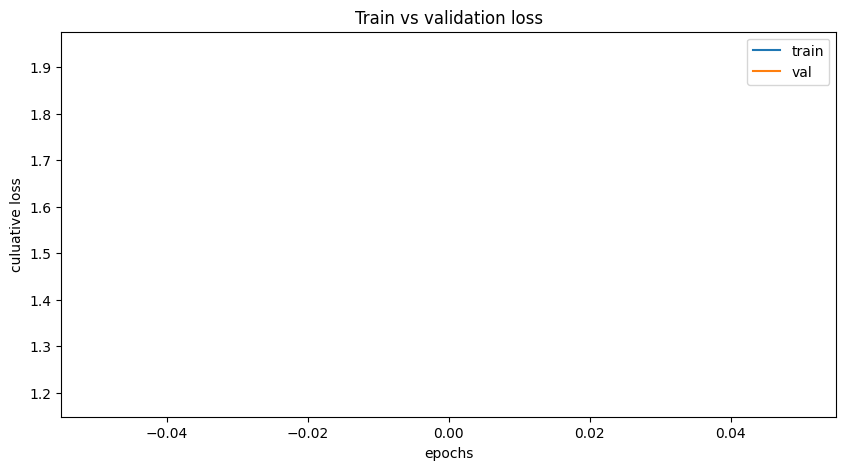

In [10]:
plt.figure(figsize=(10,5))
plt.title("Train vs validation loss")
plt.plot(train_losses,label="train")
plt.plot(val_losses,label="val")
plt.xlabel("epochs")
plt.ylabel("culuative loss")
plt.legend()
plt.show()

## Task

**Task 1:**: Run all the code to train a model. While that is running look at this code and compare it side-by-side with the image classifier training code from Week 3. What are the main differences? What code is unchanged between the two approaches?

**Task 2:** Based on the code in this notebook, create a new dataset class and data loader to load in the test dataset (see `speech-commands/test`) and get a cumulative score for the accuracy, just like what has been done with the validation set. What is the score for the test set?

### Bonus tasks

Here are some bonus tasks if you want to take this work further. You do not need to do these in order:

**Task A:** Can you use this code to train a model on a different audio classificaiton dataset?

**Task B:** Can you take your trained model and build it into an interactive application that responds to voice commands? The words used for training are the names of the folders in the training set.

**Task C:** Can you change [the transform to be calculate an MFCC](https://pytorch.org/audio/main/generated/torchaudio.transforms.MFCC.html) (Mel-Frequence Cepstrum Coefficient) instead of training the network on a raw waveform? There are a couple of ways of doing this:
- **Approach A:** [Change the downsampling transform](https://pytorch.org/audio/main/generated/torchaudio.transforms.MFCC.html) to calculate an MFCC instead. Then in the collate function (`src/audio_folder_collate_fn.py`) you can flatten the 2D MFCC respresentation into a 1-D vector before all the vectors then get padded to the same length. This way you can continue to use the 1-D CNN in this notebook. 
- **Approach B:** Keep the downsampling transform the same. Instead, calculate the MFCC in the collate function after padding has been applied (`src/audio_folder_collate_fn.py`), this way all the MFCCs will have the same dimensionality. Instead of flattening the MFCC matricies into vectors, you can then repace the [1D CNN code](#define-the-network) with a 2-D CNN instead and train a classifier on the MFCC matricies (You can borrow coe from Week 3 for this).




### Task 2 solutions

In [11]:
test_path = '../data/class-datasets/speech-commands/test/'
dataset = AudioFolder(train_path, transform=transform)
test_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_audio_folder_batch, shuffle=True)

In [14]:
model.to(device)
with torch.no_grad():
    test_loss = 0.0
    test_correct = 0.0
    for data, target in test_loader:
        
        # Move data to whatever device we are running training on
        data = data.to(device)
        target = target.to(device)

        # Forward pass with the model
        output = model(data)

        # Evaluate classification accuracy
        loss = criterion(output.squeeze(), target)
        
        # Track loss
        val_loss += loss.item()

        # Get top prediction
        pred = get_likely_index(output)
        
        # Check if prediction is correct
        test_correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

print(test_correct)

62014.0
